In [39]:
import os

import holoviews as hv
import numpy as np
import lancet

from topo.analysis.command import *
from featuremapper.analysis.raster import fft_power
from featuremapper.analysis.pinwheels import PinwheelAnalysis
from featuremapper.analysis.hypercolumns import PowerSpectrumAnalysis
from topo.analysis.command import *

import topo
from topo.analysis import Collector
from topo.submodel.gcal import ArraySpec

from topo.command import runscript  # In order to check the model files load correctly
from topo.misc.lancext import RunBatchCommand, topo_metadata

from analysis import *
from components.lespi import ModelSEPI, ModelLESPI

## Experimental Setup

In [7]:
batch_name = 'SEPI_linearity'

# Model options
laterals = False

# Measurements
isosuppression = False
sizetuning = False
frequencytuning = False
complexity = False
isosuppression = False
flankers = False

# Define times
times = [1000*i for i in range(21)]
print("Collection times start at %s and end at %s" % (min(times), max(times)))

# Define Args
constants = lancet.Args(area=3.0, laterals=laterals)
parameter_space = lancet.Range('pv_timeconstant', 0, 1, 11) * lancet.Range('pv_exponent', 0.5, 1.5, 11)
batch_arguments =  constants * parameter_space * lancet.Args(times=times)

Collection times start at 0 and end at 20000


## Load model

In [8]:
topo.sim.model = ModelSEPI(laterals=laterals)
sepi = topo.sim.model.specification

### Define Collector

In [9]:
c = Collector()

# Sheet activities
c.Activity.Retina =         c.collect(sepi.sheets.Retina)
c.Activity.V1Exc  =         c.collect(sepi.sheets.V1Exc)
c.Activity.V1PV   =         c.collect(sepi.sheets.V1PV)
# Connection fields
c.CFs.LGNOnAfferent =       c.collect(sepi.projections.V1Exc.LGNOnAfferent,  grid=True)
c.CFs.LGNOffAfferent =      c.collect(sepi.projections.V1Exc.LGNOffAfferent, grid=True)
c.CFs.PVLGNOnAfferent =       c.collect(sepi.projections.V1PV.LGNOnAfferent,  grid=True)
c.CFs.PVLGNOffAfferent =      c.collect(sepi.projections.V1PV.LGNOffAfferent, grid=True)
c.CFs.PV2Exc =   c.collect(sepi.projections.V1Exc.PVInhibition, grid=True)
c.CFs.Exc2PV =   c.collect(sepi.projections.V1PV.LateralPV, grid=True)
if laterals:
    c.CFS.LateralExcitatory = c.collect(sepi.projections.V1Exc.LateralExcitatory, grid=True)

# OR preference measurement
c.collect(measure_or_pref)
# Sheet activities
c.Activity.Retina =         c.collect(sepi.sheets.Retina)
c.Activity.V1Exc =             c.collect(sepi.sheets.V1Exc)

# Homeostatic threshold
c.HomeostaticThreshold.V1Exc = c.collect(ArraySpec('V1Exc.output_fns[0].t'),
                                         group='Homeostatic Threshold')

# OR preference measurement
c.collect(measure_or_pref, frequencies=[1.4, 1.6, 1.8])
c.collect(measure_response, durations=list(np.linspace(0,1,21)))

# Analysis
c.Pinwheels.V1Exc =            c.analyze(c.ref.OrientationPreference.V1Exc
                                         * c.ref.OrientationSelectivity.V1Exc, PinwheelAnalysis)
c.FFTAnalysis.V1Exc =          c.analyze(c.ref.OrientationPreference.V1Exc, PowerSpectrumAnalysis)

## Launcher

In [8]:
# Local or on cluster
QSUB = True
# Open diff in pager or not
SHOW_DIFF = True

ty_file = './sepi.ty'
metadata = topo_metadata()
output_directory = os.path.join(os.getcwd(), 'data')

lancet.review_and_launch.output_directory = output_directory


qsub_options = dict(b='y',
                    pe=('sharedmem', '4'),   # Parallel environment allocation
                    v='OMP_NUM_THREADS=4')   # Must match slot allocation above.
                    #l='h_rt=05:59:00',       # Time resource allocation)

@lancet.review_and_launch()
def launch():
    runbatch_cmd = RunBatchCommand(ty_file, c, metadata=batch_arguments.varying_keys, snapshot=False)
    Launcher = lancet.QLauncher if QSUB else lancet.Launcher
    return Launcher(batch_name, batch_arguments, runbatch_cmd,  metadata=metadata(), 
                    **({'qsub_flag_options':qsub_options} if QSUB else {}))
launch()


| Arguments Summary |

Items: 121
Varying Keys: 'pv_timeconstant', 'pv_exponent'
Constant Items: area=3.0, laterals=False, times=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]

Show available argument specifier entries? [y, N, quit]: 

| RunBatchCommand Summary |

Command executable: /exports/eddie/scratch/s1048519/topographica/topographica
Collector definition summary:

15 tasks scheduled:

  01.  Activity.Retina
           SheetSpec
  02.  Activity.V1Exc
           SheetSpec
  03.  Activity.V1PV
           SheetSpec
  04.  CFs.LGNOnAfferent
           ProjectionSpec [grid=True]
  05.  CFs.LGNOffAfferent
           ProjectionSpec [grid=True]
  06.  CFs.PVLGNOnAfferent
           ProjectionSpec [grid=True]
  07.  CFs.PVLGNOffAfferent
           ProjectionSpec [grid=True]
  08.  CFs.PV2Exc
           ProjectionSpec [grid=True]
  09.  CFs.Exc2PV
           ProjectionSpec [grid=True]
  10.  [...] 
   

Time: 000000.00 QLauncher: Invoked qsub for 121 commands


True

# Loading data and progress report

In [40]:
import holoviews as hv
from analysis.progress import ProgressWidget, load_table
hv.notebook_extension('bokeh', width=95)

In [41]:
path = './data/2016-05-13_1245-SEPI_linearity/'
ProgressWidget(path)

:Layout
   .DynamicMap.I   :DynamicMap   [Time]
   .DynamicMap.II  :DynamicMap   [Time]
   .DynamicMap.III :DynamicMap   [Time]
   .DynamicMap.IV  :DynamicMap   [Time]

In [42]:
from holoviews.core.io import Unpickler
table = load_table(path)
data = Unpickler.collect(table, drop=['time', 'Index', 'tid', 'timestamps'])

## Robustness - Similarity, Selectivity, Map quality

In [43]:
hv.notebook_extension('matplotlib')
%output max_frames=10000 widgets='live'

In [44]:
orpref = data.OrientationPreference.V1Exc() 
orsel  = data.OrientationSelectivity.V1Exc()

:Layout
   .Orientation_Preference.V1Exc  :HoloMap   [pv_exponent,pv_timeconstant,Time,Duration]
      :Image   [x,y]   (Orientation Preference)
   .Orientation_Selectivity.V1Exc :HoloMap   [pv_exponent,pv_timeconstant,Time,Duration]
      :Image   [x,y]   (Orientation Selectivity)
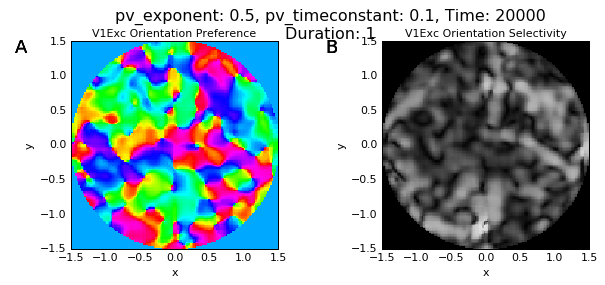

In [45]:
(orpref + orsel).select(Time=20000)

In [47]:
pvorsel = data.OrientationSelectivity.V1PV()

### Similarity

In [52]:
from analysis import similarity_analysis

In [53]:
dims = ['pv_timeconstant', 'pv_exponent']
maps = orpref.reindex().select(x=(-1,1), y=(-1,1)).groupby(dims)
similarity = hv.HoloMap(kdims=dims)
for k, m in maps.items():
    if 20000 in m.keys():
        similarity[k] = similarity_analysis(m).reduce(['x', 'y'], np.mean).to.curve(['Time'], ['z'])

:HeatMap   [pv_timeconstant,pv_exponent]   (Stability)
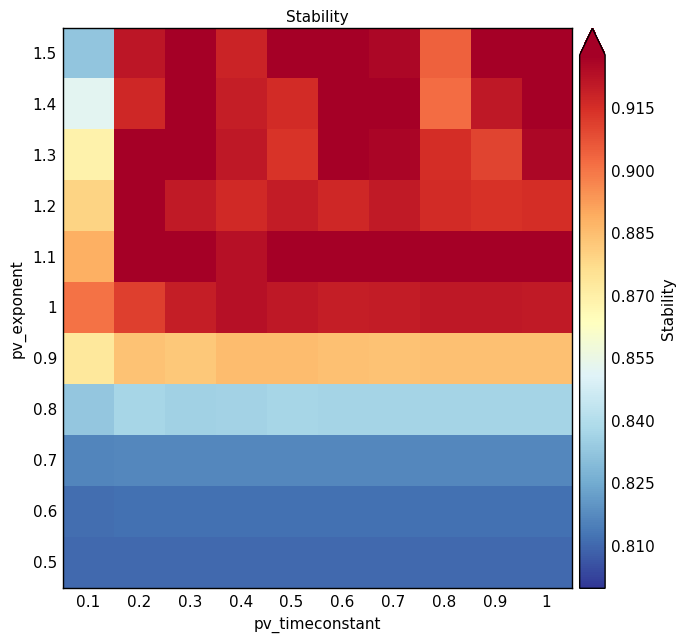

In [54]:
%%output size=200 dpi=100
%%opts HeatMap (clims=(0.8, 0.928)) [colorbar=True show_values=False]
similarity_hm = similarity.reduce(['Time'], np.mean).table(datatype='dataframe').to.heatmap(dims, ['z'], group='Stability')
similarity_hm.data = similarity_hm.data.rename(columns={'z': 'Stability'})
similarity_hm.vdims = [hv.Dimension('Stability')]
similarity_hm

### Selectivity

In [25]:
maps = orsel.reindex().groupby(dims)
selectivity = hv.HoloMap(kdims=dims)
for k, sel in maps.items():
    if 20000 in m.keys():
        selectivity[k] = sel.select(x=(-1, 1), y=(-1, 1)).reduce(['x', 'y'], np.mean)

:HeatMap   [pv_timeconstant,pv_exponent]   (Orientation Selectivity)
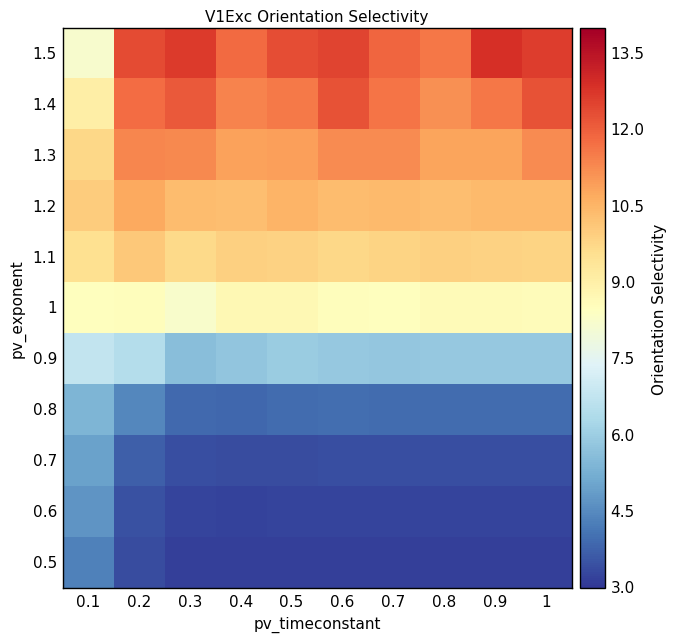

In [26]:
%%output size=200 dpi=100
%%opts HeatMap (clims=(3, 14)) [show_values=False colorbar=True]
selectivity_hm = selectivity.reduce(['Time'], np.mean).to.heatmap(group='Orientation Selectivity')
selectivity_hm

In [49]:
maps = pvorsel.reindex().groupby(dims)
pvselectivity = hv.HoloMap(kdims=dims)
for k, sel in maps.items():
    if 20000 in m.keys():
        pvselectivity[k] = sel.select(x=(-1, 1), y=(-1, 1)).reduce(['x', 'y'], np.mean)

:HeatMap   [pv_timeconstant,pv_exponent]   (Orientation Selectivity)
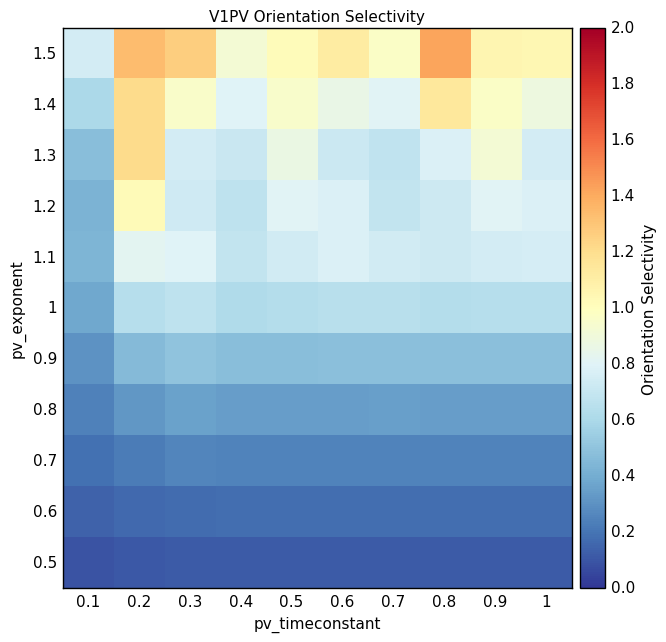

In [62]:
%%output size=200 dpi=100
%%opts HeatMap (clims=(0, 2)) [show_values=False colorbar=True]
pvselectivity_hm = pvselectivity.reduce(['Time'], np.mean).to.heatmap(group='Orientation Selectivity')
pvselectivity_hm

## Pinwheel Density

In [14]:
orpref_20k = orpref.select(Time=20000, x=(-1, 1), y=(-1, 1))

In [15]:
pinwheel_results = hv.HoloMap(kdims=dims)
for k, group in orpref_20k.groupby(dims).items():
    try:
        pinwheel_results[k] = PowerSpectrumAnalysis(group, gamma_k=3.0)
    except Exception as e:
        print e
        pass
pinwheel_results = pinwheel_results.collate()
pwd_metrics = pinwheel_results.PowerSpectrum_Analysis.V1Exc.dframe()

/Users/philippjfr/miniconda/envs/science/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


:Layout
   .Pinwheel_Density.I        :HeatMap   [pv_timeconstant,pv_exponent]   (rho)
   .Pinwheel_Density_Metric.I :HeatMap   [pv_timeconstant,pv_exponent]   (rho_metric)
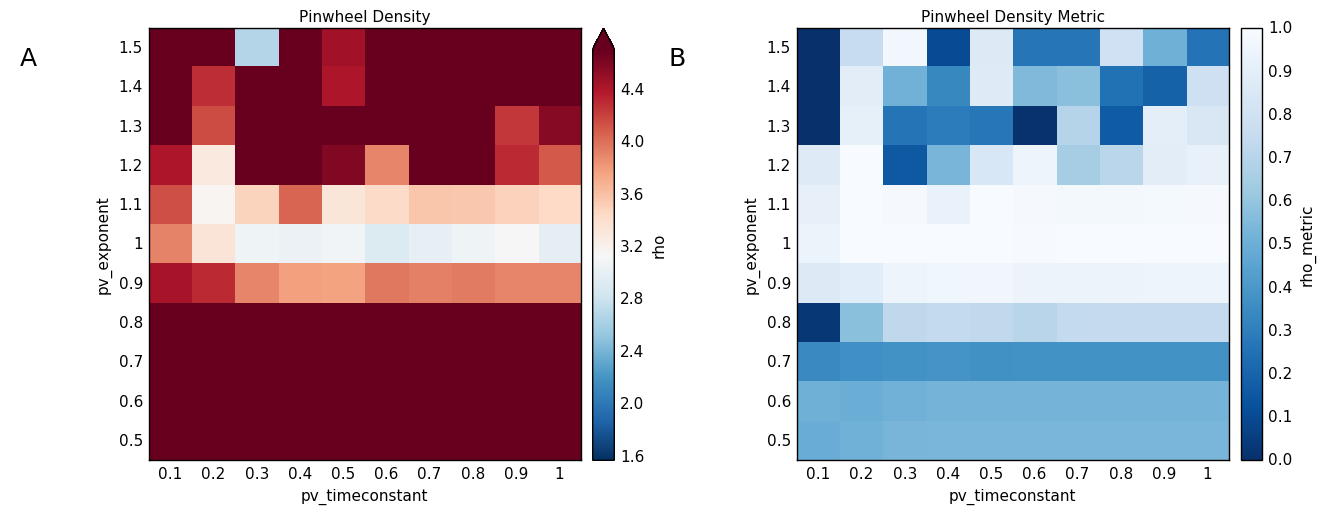

In [27]:
%%output size=150 dpi=100
%%opts HeatMap.Pinwheel_Density (clims=(np.pi/2., np.pi*1.5) cmap='RdBu_r') [show_values=False colorbar=True]
%%opts HeatMap.Pinwheel_Density_Metric (clims=(0, 1) cmap='Blues_r') [show_values=False colorbar=True]
pwdm = hv.Table(pwd_metrics).to.heatmap(dims, ['rho_metric'], [], group='Pinwheel Density Metric')
pwd = hv.Table(pwd_metrics).to.heatmap(dims, ['rho'], [], group='Pinwheel Density')
pwd + pwdm

## Local Homogeneity Index

In [17]:
import analysis

In [18]:
lhi_20k = analysis.LocalHomogeneityIndex(orpref_20k)
lhi_table = lhi_20k.reduce(function=np.mean)

:HoloMap   [Time,Duration]
   :HeatMap   [pv_timeconstant,pv_exponent]   (LHI)
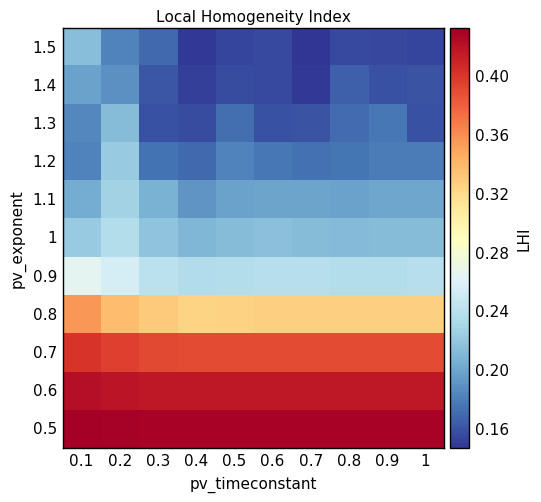

In [19]:
%%output size=150 dpi=100
%%opts HeatMap [show_values=False colorbar=True]
lhi = lhi_table.to.heatmap(dims).relabel(label='')
lhi

## Center-of-Gravity Shift

In [20]:
lgn_on = data.CFs.LGNOnAfferent.select(time=20000)().select(X=(-1, 1), Y=(-1, 1))
grouped_cfs = hv.Collator(lgn_on, merge_type=hv.HoloMap, kdims=lgn_on.kdims)().reindex().groupby(dims)

In [37]:
distance_map = {}
for (tc, exp), group in grouped_cfs.items():
    if len(group):
        total_distance = 0
    else:
        total_distance = np.NaN
    for (x, y), cf in group.items():
        cf_df = cf.dframe()
        normed_weights = 1/np.sum(cf_df)
        cogx = np.sum(cf_df.x * cf_df.z)
        cogy = np.sum(cf_df.y * cf_df.z)
        total_distance += np.sqrt(((cogx - x)**2) + ((cogy - y)**2))
    distance_map[tc, exp] = total_distance/len(group)

:HeatMap   [pv_timeconstant,pv_exponent]   (CoG Shift)
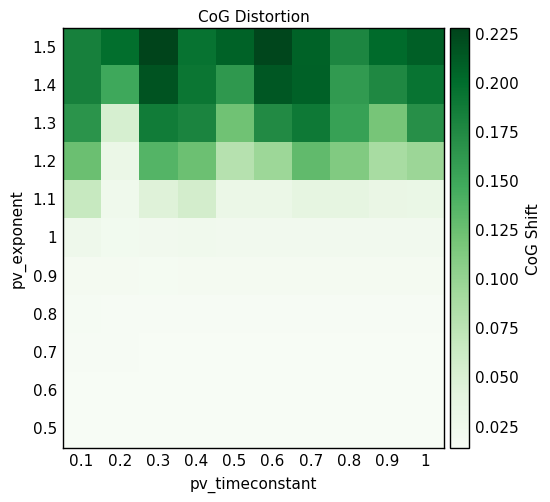

In [38]:
%%output size=150 dpi=100
%%opts HeatMap [show_values=False colorbar=True] (cmap='Greens')
cog = hv.HeatMap(distance_map, group='CoG Distortion', kdims=dims, vdims=['CoG Shift']).sort()
cog

## Overview

In [65]:
%%output size=150 dpi=100 fig='svg' filename='SEPI_Linearity'
%%opts Layout [hspace=0.5 vspace=0.]
%%opts HeatMap [sublabel_position=(-0.25, 0.9) show_frame=True colorbar=True sublabel_size=24 fontsize={'title':20,'xlabel':16,'ylabel':16,'ticks':16} show_values=False] {+framewise}
%%opts HeatMap.Stability (cmap='Blues' clims=(0.8, 1)) [cbar_ticks=[0.8, 0.85, 0.9, 0.95, 1]]
%%opts HeatMap.Orientation_Selectivity (cmap='Reds' clims=(0, 10))
%%opts HeatMap.Local_Homogeneity_Index (cmap='Purples' clims=(0, 0.5))
%%opts HeatMap.Pinwheel_Density [cbar_ticks=[(np.pi/2., r'$\pi/2$'), (np.pi, r'$\pi$'), (np.pi, r'$\pi$'), (np.pi*1.5, r'$3(\pi/2)$')]] (cmap='RdBu_r')
%%opts HeatMap.CoG_Distortion (clims=(0, 0.4))
%%opts HeatMap.Orientation_Selectivity.V1PV (clims=(0,2))
linearity = similarity_hm + selectivity_hm.clone(label='') + lhi.last + pwd + cog + pvselectivity_hm
linearity.cols(3) 

:Layout
   .Stability.I                  :HeatMap   [pv_timeconstant,pv_exponent]   (Stability)
   .Orientation_Selectivity.I    :HeatMap   [pv_timeconstant,pv_exponent]   (Orientation Selectivity)
   .Local_Homogeneity_Index.I    :HeatMap   [pv_timeconstant,pv_exponent]   (LHI)
   .Pinwheel_Density.I           :HeatMap   [pv_timeconstant,pv_exponent]   (rho)
   .CoG_Distortion.I             :HeatMap   [pv_timeconstant,pv_exponent]   (CoG Shift)
   .Orientation_Selectivity.V1PV :HeatMap   [pv_timeconstant,pv_exponent]   (Orientation Selectivity)

In [57]:
metrics = None
for metric in linearity + pwdm:
    if metrics is None:
        metrics = metric.dframe()
    else:
        metrics = metrics.merge(metric.dframe(), on=dims)

# Correlations

In [64]:
%%output size=200 fig='svg' filename='SEPI_Linearity_Correlations'
%%opts Overlay [xrotation=90 invert_yaxis=True show_frame=False] VLine (color='w' lw=7) HLine (color='w' lw=7)
%%opts HeatMap [colorbar=True show_values=False ] (clims=(-1, 1) cmap='RdBu_r')
corr = metrics.corr()
corr = corr.reindex_axis([c for c in sorted(corr.columns) if c != 'rho'], axis=1)
hv.HeatMap([((c, c2), corr[c][c2] if c != c2 else np.NaN) for i, c in enumerate(corr)
            for c2 in corr.columns[i+1:]], kdims=[' ', '  '],  vdims=['Pearson Correlation']) *\
hv.Overlay([hv.VLine(i) for i in range(7)]) * hv.Overlay([hv.HLine(i) for i in range(7)])

:Overlay
   .HeatMap.I :HeatMap   [ ,  ]   (Pearson Correlation)
   .VLine.I   :VLine   [x,y]
   .VLine.II  :VLine   [x,y]
   .VLine.III :VLine   [x,y]
   .VLine.IV  :VLine   [x,y]
   .VLine.V   :VLine   [x,y]
   .VLine.VI  :VLine   [x,y]
   .VLine.VII :VLine   [x,y]
   .HLine.I   :HLine   [x,y]
   .HLine.II  :HLine   [x,y]
   .HLine.III :HLine   [x,y]
   .HLine.IV  :HLine   [x,y]
   .HLine.V   :HLine   [x,y]
   .HLine.VI  :HLine   [x,y]
   .HLine.VII :HLine   [x,y]